# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

Ran with MDPL. Were able to match the SMF. But with that bestfit, clustering was way off - ~5x more clustering in HSC than in the sim.

Now trying with SMDPL from the UM - this should have better clustering because the UM tracks disrupted halos. (It doesn't - we probably have a bug)

**Bugs to check**

1) One of our clustering estimates is wrong. (no, corrfunc and halotools argree in the theory case and corrfunc and my func agree in the obs case)

2) We are using MPc in one of theory/obs and MPc/h in the other (no cosmo.comovingDistance gives MPc/h and SMDPL distances are in MPc/h)
  **Actual bug** Nope! The SMF in the obs data is in MPC!

3) One of these is using different masses Msun vs Msun/h (does that matter because we match the SMF of the sim to whatever it is in the data)

4) **Actual bug** I wasn't computing the mass function correctly. I forgot to divide by the width of the mass bin. Unfortunately this pushed the clustering the wrong way...

## Import etc...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee

import data as d
import likelihood as l
import plots as p
import clustering as c


from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# Load data

In [55]:
sim_data, sim_size = d.load_mdpl()

In [4]:
obs_smf = d.load_smf()
gals = d.load_hsc_gals()

# Starting params from https://redwoodforest.slack.com/files/U5WT8PBKN/FDD17SXN0/image.png 
#params = [10**12.52, 10**10.91, 0.45, 0.6, 1.83] # m1, sm0, beta, delta, gamma
b_params = [12.52, 10.91, 0.6] # Fix beta and gamma
s_params = [-0.06, 1.08]

# array([12.4506438 , 10.88120647,  0.61182347, -0.0612849 ,  1.07830828])
# Best from mdpl but something is wrong with clustering
b_params = [12.4506438 , 10.88120647,  0.64241464]
s_params = [-0.0612849 ,  1.07830828]

# Best when I think I have the wrong mpc/h fix
#b_params = [13.29021731, 10.84259742,  0.62103008]
#s_params = [-0.0594887 ,  1.11534259]

## Sanity check data

16.122023699246338 15.625


[None]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


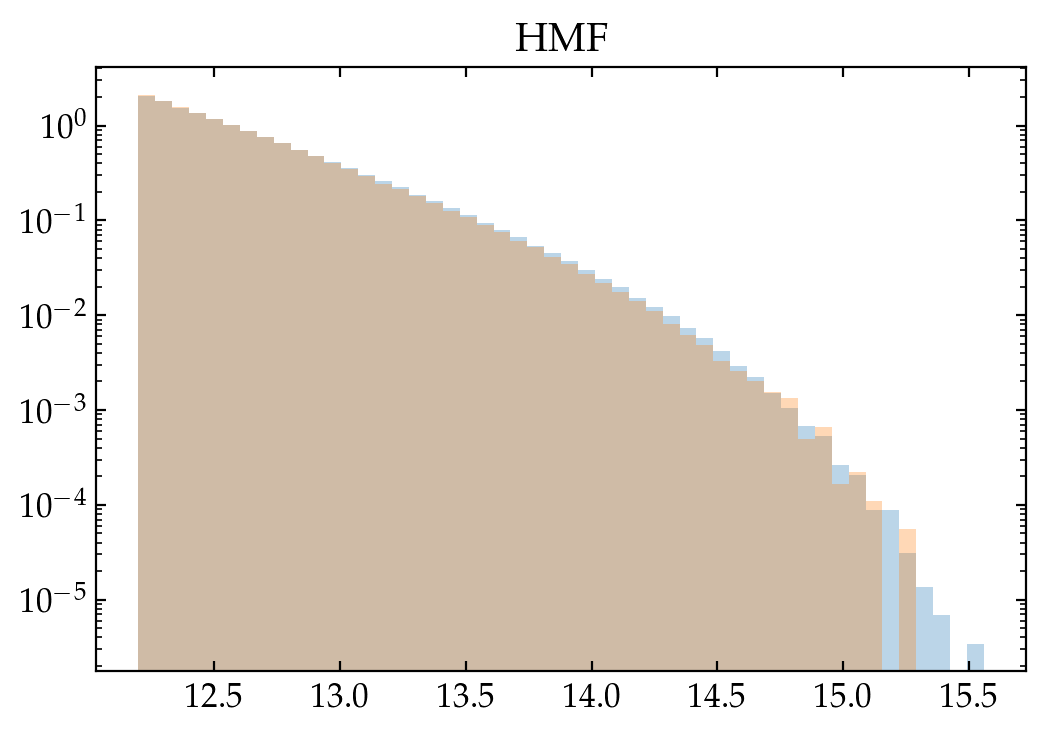

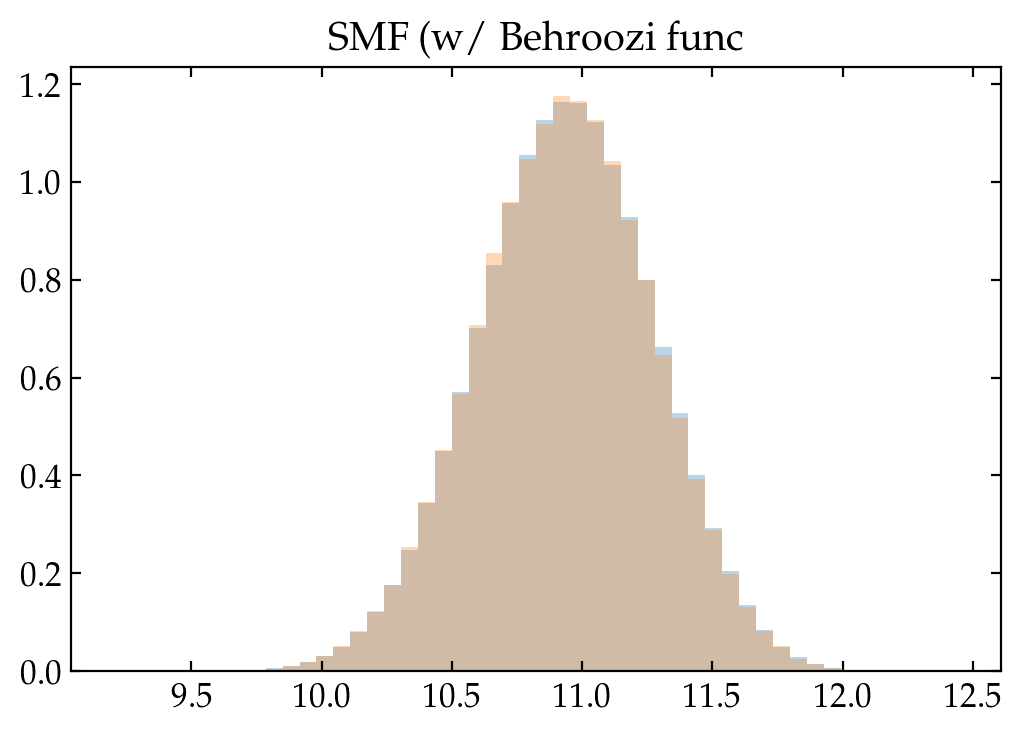

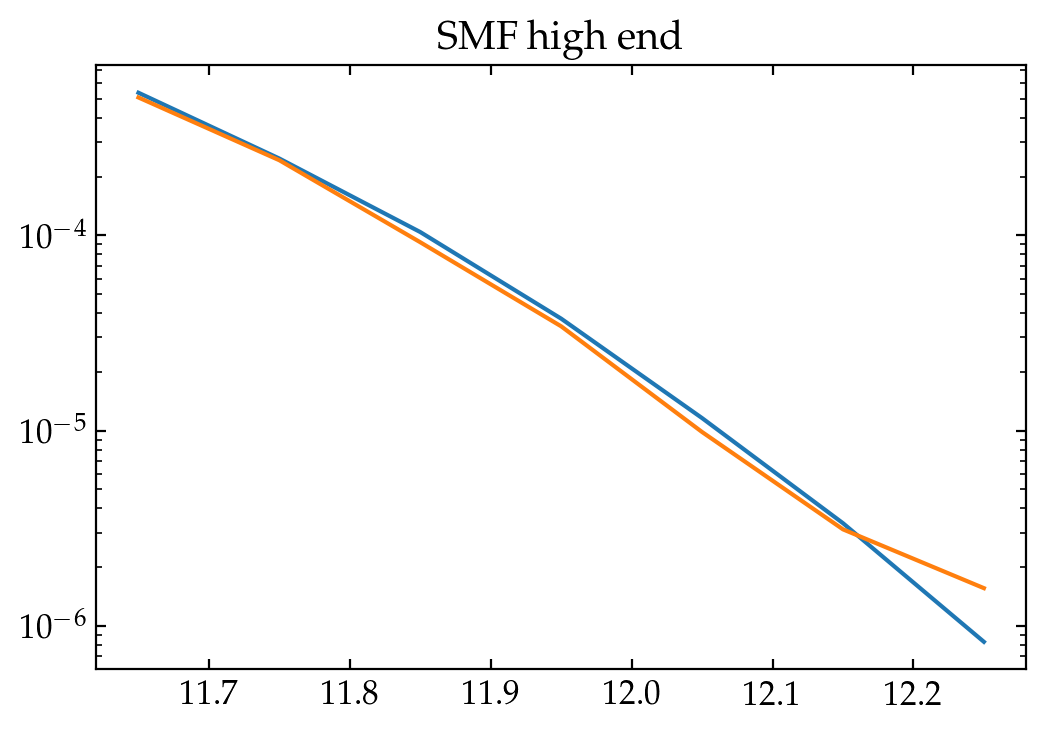

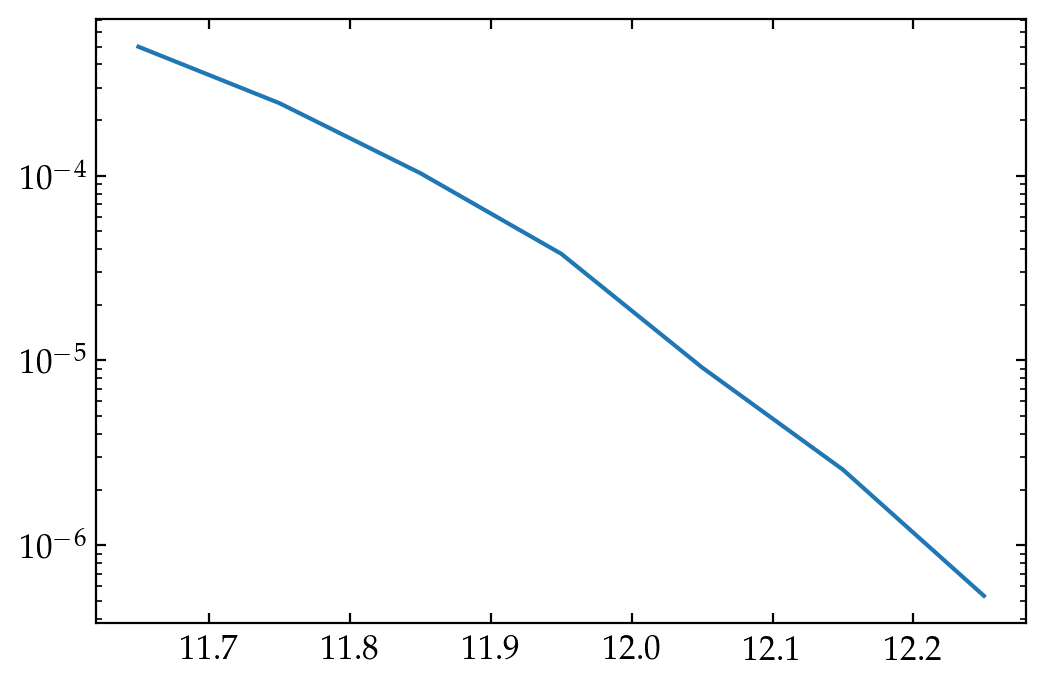

In [55]:
# Halo masses should be similar in smdpl and mdpl
mdpl, mdpl_size = d.load_mdpl()
smdpl, smdpl_size = d.load_smdpl()

_, ax = plt.subplots()
_, bins, _ = ax.hist(np.log10(mdpl["halo_mvir"]), bins=50, density=True, alpha=0.3)
ax.hist(np.log10(smdpl["halo_mvir"]), bins=bins, density=True, alpha=0.3)
ax.set(yscale="log", title="HMF")

# Stellar masses should be similar
mdpl_sm = get_sm_for_sim(mdpl, b_params, s_params)
smdpl_sm = get_sm_for_sim(smdpl, b_params, s_params)

_, ax = plt.subplots()
_, bins, _ = ax.hist(mdpl_sm, bins=50, density=True, alpha=0.3)
ax.hist(smdpl_sm, bins=bins, density=True, alpha=0.3)
ax.set(title="SMF (w/ Behroozi func)")

# The SMF should be similar
sm_bins = np.linspace(11.6, 12.3, 8)
sm_bin_centers = (sm_bins[:-1] + sm_bins[1:]) / 2

_, ax = plt.subplots()
ax.plot(sm_bin_centers, get_smf(mdpl_sm, sm_bins, mdpl_size**3))
ax.plot(sm_bin_centers, get_smf(smdpl_sm, sm_bins, smdpl_size**3))
ax.set(yscale="log", title="SMF high end")

# The ratio of the number of galaxies should be similar to the ratio of volumes
print(len(mdpl) / len(smdpl), mdpl_size**3 / smdpl_size**3)

# Smf should be quite a bit larger than 1e-4 at 11.6 (different to fig 4 https://arxiv.org/pdf/1707.01904.pdf)
_, ax = plt.subplots()
plt.plot(obs_smf["logm_mean"], obs_smf["smf"])
ax.set(yscale="log")

# MCMC the params

I don't think we actually want to do this - we want an optimizer

In [43]:
nwalkers = 64
params = b_params + s_params
ndim = len(params)
start_positions = np.array([params * (np.random.random(size=ndim)/20 + 0.975) for i in range(nwalkers)]) # peturbed best fit positions

sampler = emcee.EnsembleSampler(nwalkers, ndim, l.single_step, args=[sim_data, obs_smf], threads=32)
_ = sampler.run_mcmc(start_positions, 100) # Roughly 30s per step

negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter


/home/christopher/research/hsc_um2/cb/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatter
negative scatt

In [ ]:
sampler.run_mcmc(None, 1500)

## Plot MCMC

49.961758023056426
[12.33361471 11.06954566  0.59570586 -0.0612304   1.06639163]
[12.52, 10.91, 0.6] [-0.06, 1.08]


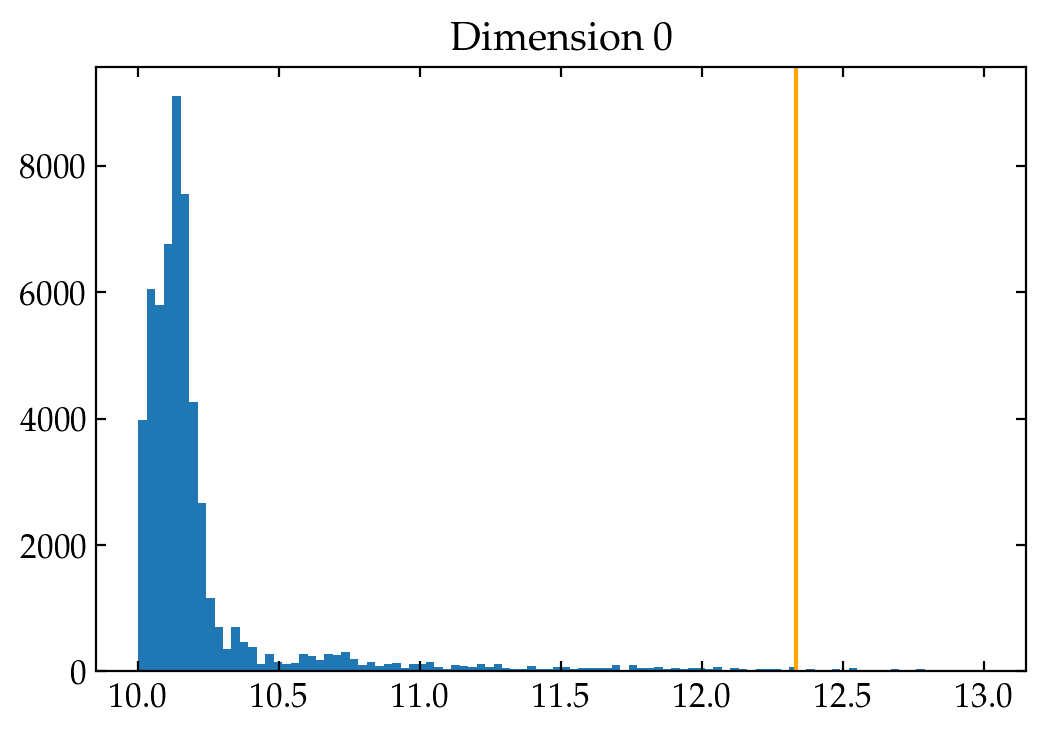

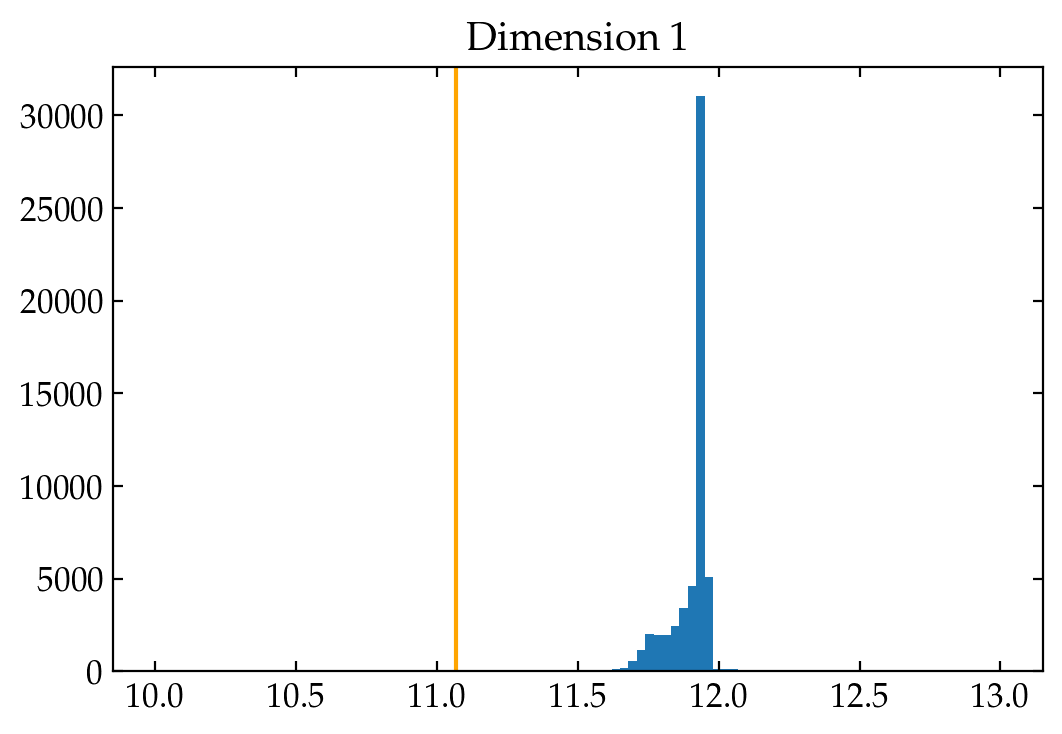

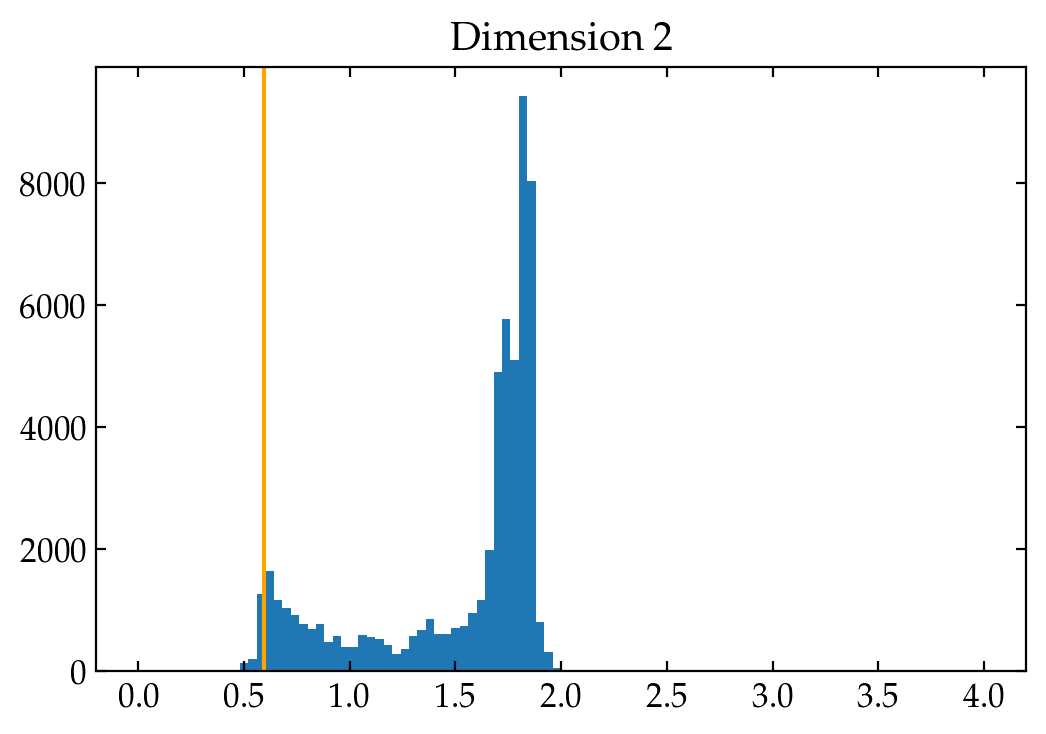

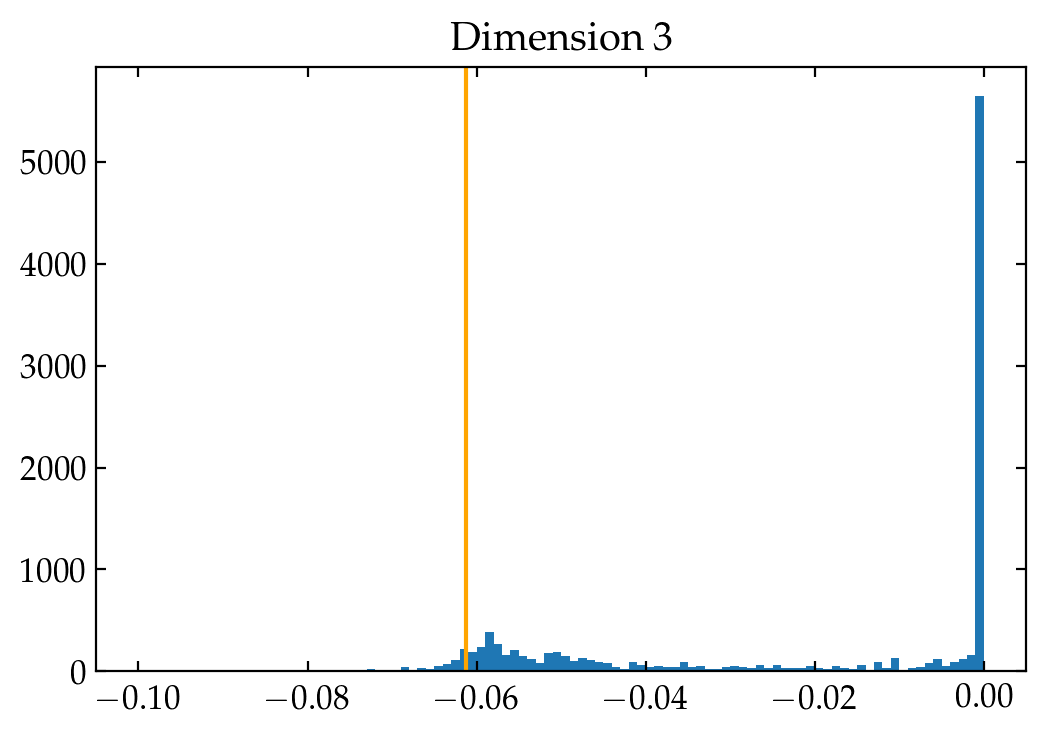

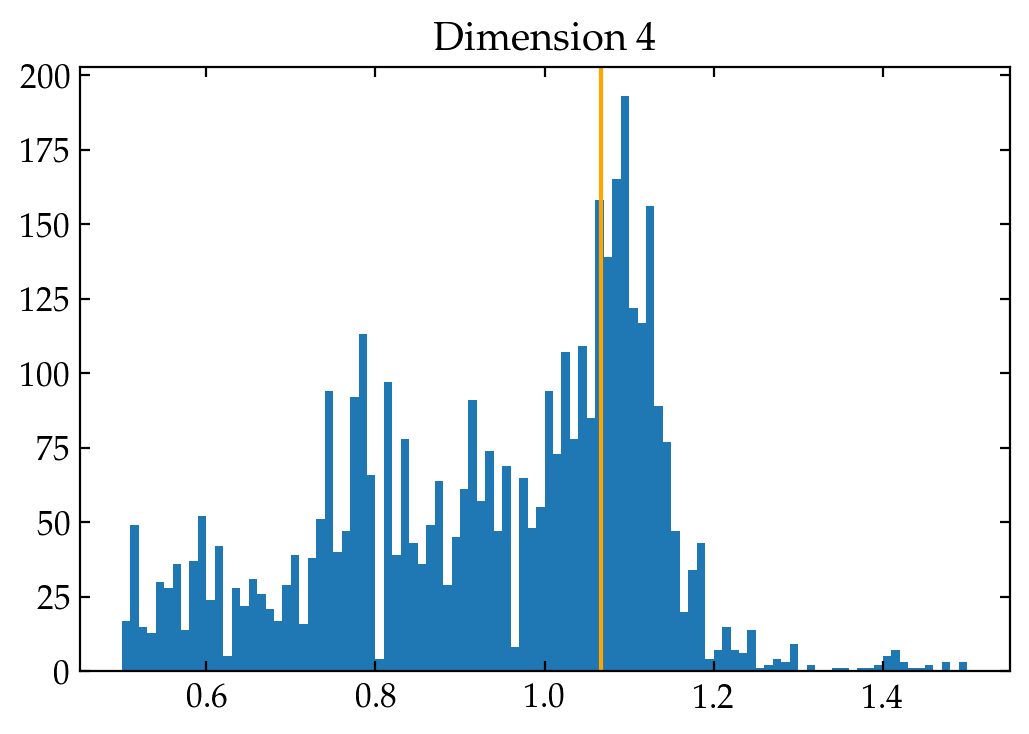

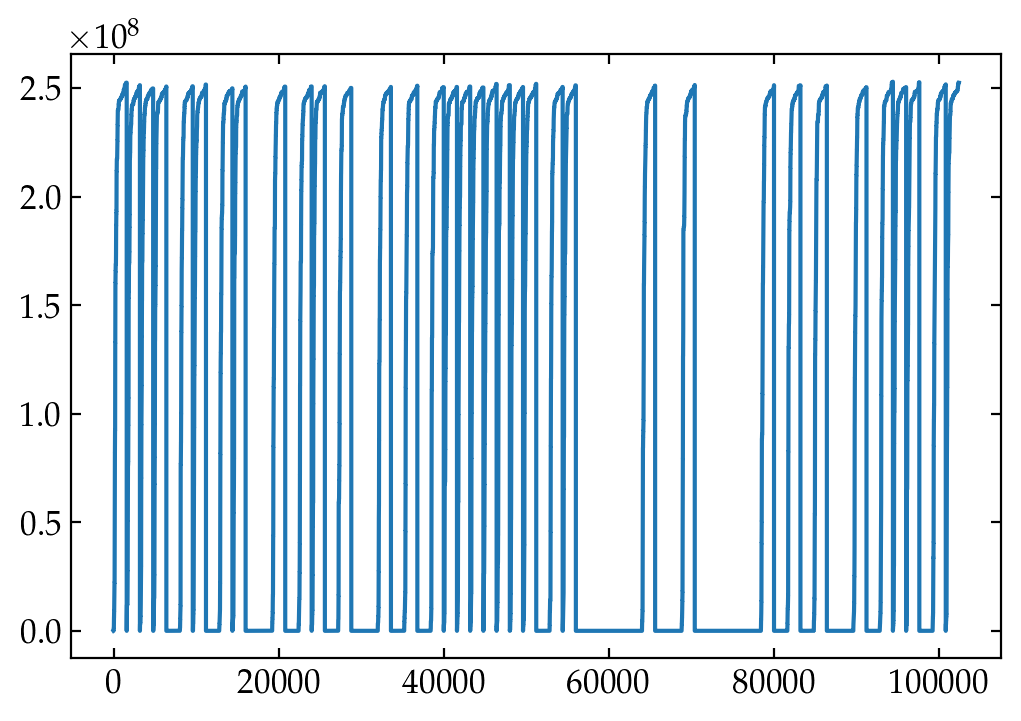

In [65]:
best_p = sampler.flatchain[
    sampler.flatlnprobability == np.min(sampler.flatlnprobability)
][0]
print(np.min(sampler.flatlnprobability))
print(best_p)
print(b_params, s_params)

ranges =[(10, 13), (10, 13), (0, 4), (-0.1, 0), (0.5, 1.5)]
for i in range(ndim):
    _, ax = plt.subplots()
    ax.hist(sampler.flatchain[:,i], bins=100, range=ranges[i])
    #ax.plot(sampler.chain[3,:,i])
    ax.set(title="Dimension {0:d}".format(i))
    ax.axvline(best_p[i], color="orange")

_, ax = plt.subplots()
ax.plot(sampler.flatlnprobability)

# Find bestfit to SMF with optimizer

In [56]:
params = b_params + s_params
res = scipy.optimize.minimize(
    l.single_step_avg,
    x0 = params,
    args=(sim_data, obs_smf, sim_size, 1),
    method="Nelder-Mead",
    tol=1,
)
assert res.success == True

[12.4506438  10.88120647  0.64241464 -0.0612849   1.07830828]
4.948392505491534
[13.07317599 10.88120647  0.64241464 -0.0612849   1.07830828]
329.144099631595
[12.4506438  11.42526679  0.64241464 -0.0612849   1.07830828]
662036.457665388
[12.4506438  10.88120647  0.67453537 -0.0612849   1.07830828]
1.8733067890393575
[12.4506438  10.88120647  0.64241464 -0.06434915  1.07830828]
104.71919213340475
[12.4506438  10.88120647  0.64241464 -0.0612849   1.13222369]
911.761241675075
[12.69965668 10.33714615  0.65526293 -0.0625106   1.09987445]
416.37873239926296
[12.79926183 10.66358234  0.66040225 -0.06300088  1.03301933]
416.5571559458932
[12.71210732 10.71798837  0.65590535 -0.06257188  1.05782042]
398.7438378651739
[12.55522921 11.35997955  0.64781092 -0.06179969  1.04854697]
93255.75543864127
[12.66354981 10.5928545   0.65339993 -0.06233287  1.08704258]
399.56241719887646
[12.59133607 11.1042712   0.64967393 -0.06197742  1.06137884]
1467.397645375821
[12.64549638 10.72070867  0.65246843 -0

1.1949942486467338


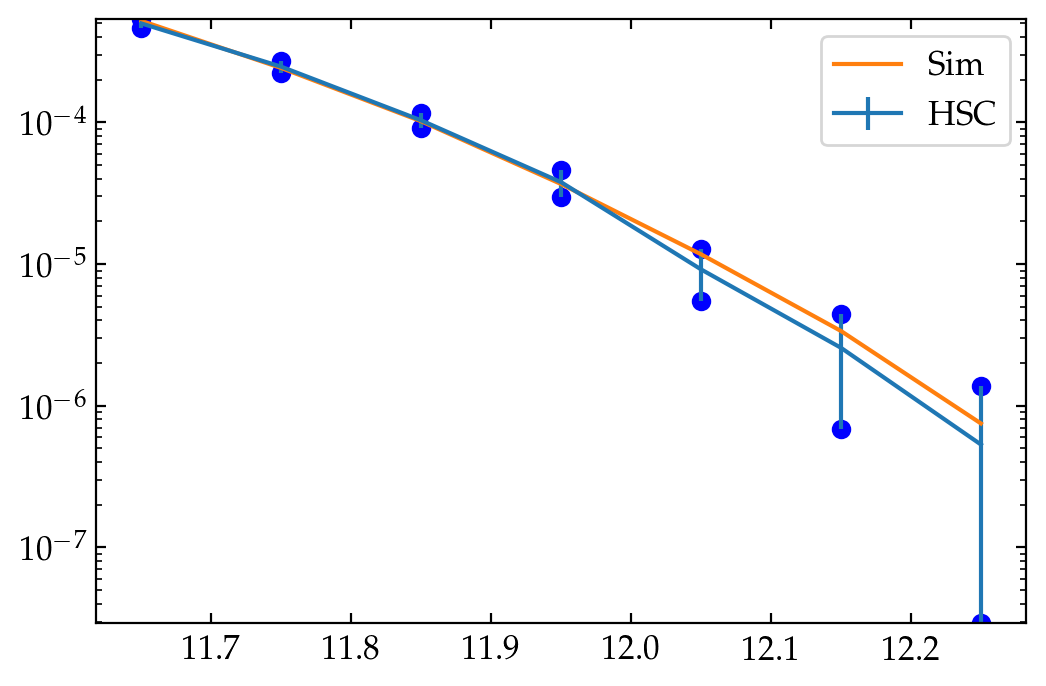

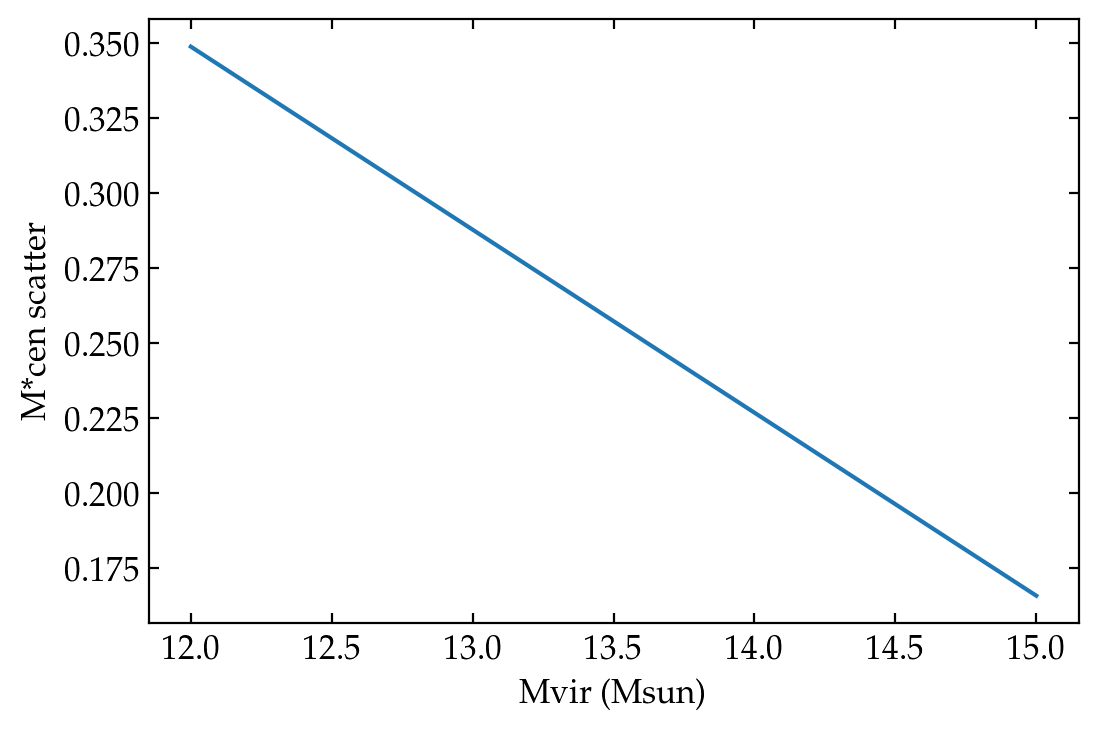

In [58]:
best_p = res.x
p.plot_smfs(sim_data, obs_smf, best_p[:3], best_p[3:], sim_size)
p.plot_scatter(best_p[3:])

# Compute and Compare Clustering

In [25]:
lower_mass_cut = 11.65
upper_mass_cut = 11.75
upper_2_mass_cut = 12

## In HSC

In [27]:
s1 = gals[
    (gals["logm_max"] > upper_mass_cut) & (gals["logm_max"] < upper_2_mass_cut)
]
s2 = gals[
    (gals["logm_max"] > lower_mass_cut) & (gals["logm_max"] < upper_mass_cut)
]

r1 = d.load_randoms(s1["z_best"])
r2 = d.load_randoms(s2["z_best"])

# Split randoms into two parts
r_div = np.arange(len(r1))[:100_000]
np.random.shuffle(r_div)
r1 = r1[r_div[:len(r_div) // 2]]
r2 = r2[r_div[len(r_div) // 2:]]
assert len(r1) == len(r2)

dd = c.obs_clustering(s1, s2)
dr = c.obs_clustering(s1, r2)
rd = c.obs_clustering(r1, s2)
rr = c.obs_clustering(r1, r2)

obs_clust = c.compute_clustering(np.sum(dd["npairs"]), np.sum(dr["npairs"]), len(s2), len(r2))
print(obs_clust)

obs_clust_cf = convert_3d_counts_to_cf(len(s1), len(s2), len(r1), len(r2), dd, dr, rd, rr)
print(np.mean(obs_clust_cf), np.mean(obs_clust_cf[:10]), obs_clust_cf)

plt.plot(obs_clust_cf)

34.25471531817381
27.67616339630132 27.67616339630132 [12.29815415 61.86354088 41.86066886 61.03652334 26.68750386  7.02374375 11.96783721 13.29204533 27.24171632 13.48990026]


## In the sim

In [54]:
log_stellar_masses = get_sm_for_sim(sim_data, best_p[:3], best_p[3:])

s1 = sim_data[
    (log_stellar_masses > upper_mass_cut) & (log_stellar_masses < upper_2_mass_cut)
]
s2 = sim_data[(log_stellar_masses > lower_mass_cut) & (log_stellar_masses < upper_mass_cut)]

r1 = sim_size * np.random.random(size=(250_000, 3))
r1 = r1.ravel().view([("halo_x", np.float64), ("halo_y", np.float64), ("halo_z", np.float64)])

r2 = sim_size * np.random.random(size=(250_000, 3))
r2 = r2.ravel().view([("halo_x", np.float64), ("halo_y", np.float64), ("halo_z", np.float64)])

dd = c.sim_clustering(s1, s2, sim_size, applyRSD1=True, applyRSD2=True)
dr = c.sim_clustering(s1, r2, sim_size, applyRSD1=True)
rd = c.sim_clustering(r1, s2, sim_size, applyRSD2=True)
rr = c.sim_clustering(r1, r2, sim_size)

sim_clust = c.compute_clustering(np.sum(dd["npairs"]), np.sum(dr["npairs"]), len(s2), len(r2))
print(sim_clust)
sim_clust_cf = convert_3d_counts_to_cf(len(s1), len(s2), len(r1), len(r2), dd, dr, rd, rr)
print(np.mean(sim_clust_cf), np.mean(sim_clust_cf[:10]), sim_clust_cf)

6.981419255972097
7.140146830751225 7.140146830751225 [-0.53376536 15.71359717 16.00007885  5.66199251  8.86567183  5.76670573  9.01507744  2.57557625  2.68485526  5.65167863]


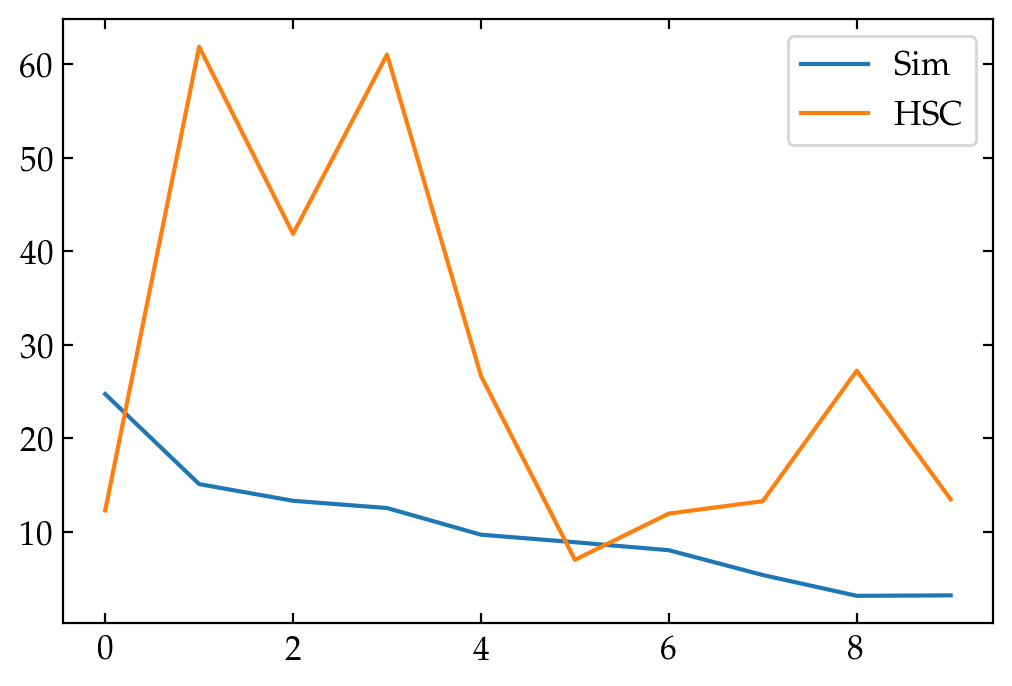

In [39]:
_, ax = plt.subplots()
ax.plot(sim_clust_cf, label="Sim")
ax.plot(obs_clust_cf, label="HSC")
ax.legend()

## Tests

[None, Text(0.5, 1.0, 'The SMFs are the same (within a scaling factor)')]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


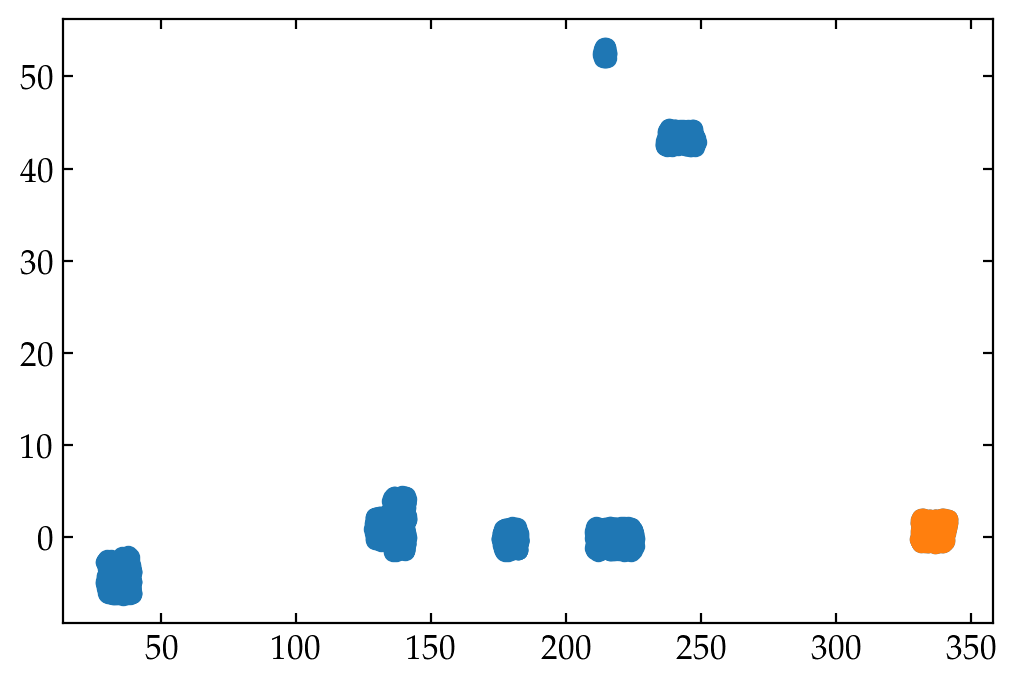

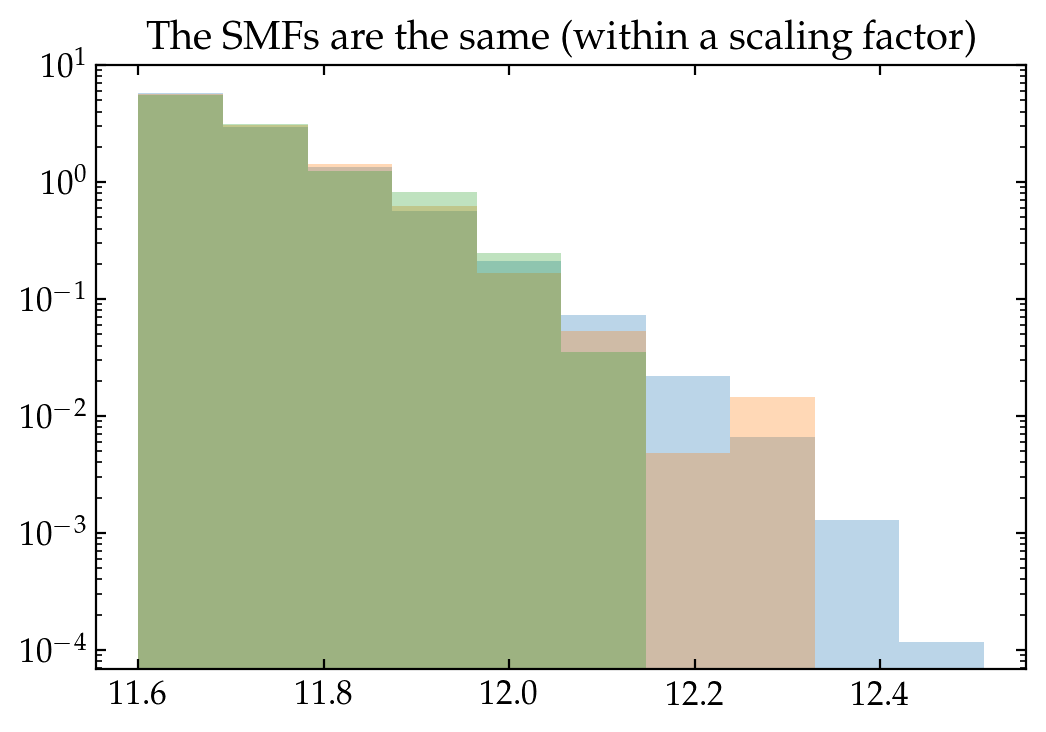

In [21]:
_, ax = plt.subplots()
ax.scatter(gals["ra"], gals["dec"])

ss_gals = gals[gals["ra"] > 300]
ax.scatter(ss_gals["ra"], ss_gals["dec"])

# Are the SMFs the same incl some multiplicative factor?
_, ax = plt.subplots()
_, bins, _ = ax.hist(log_stellar_masses[log_stellar_masses > 11.6], density=True, alpha=0.3)
ax.hist(gals["logm_max"][gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.hist(ss_gals["logm_max"][ss_gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.set(yscale="log", title="The SMFs are the same (within a scaling factor)")

No handles with labels found to put in legend.


310
93583
0.25033000111579895 0.4699699878692627
330.88113164799324 341.3245412233512
542.9176576001199 130.05682007678672 36.06198314682097 232.83135321096566 66.82396709626335
5067606.247991663


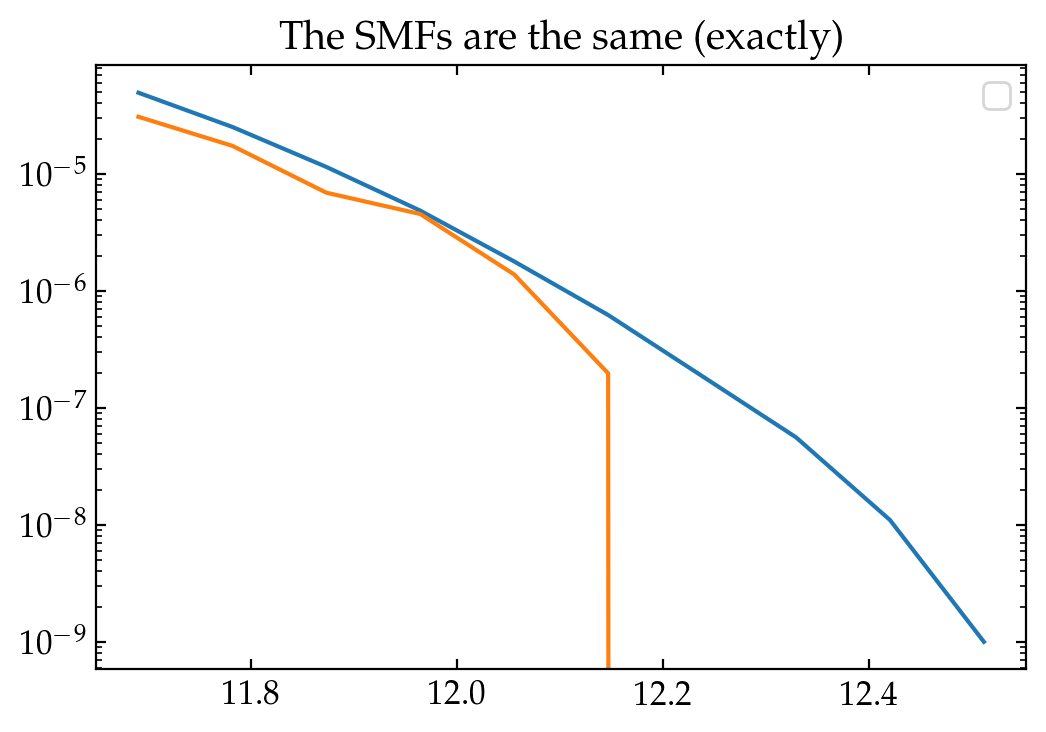

In [22]:
# How about exactly the same (need volume)
print(len(ss_gals[ss_gals["logm_max"] > 11.6]))
print(len(log_stellar_masses[log_stellar_masses > 11.6]))

min_z, max_z = np.min(ss_gals["z_best"]), np.max(ss_gals["z_best"])
min_ra, max_ra = np.min(ss_gals["ra"]), np.max(ss_gals["ra"])
min_dec, max_dec = np.min(ss_gals["dec"]), np.max(ss_gals["dec"])

print(min_z, max_z)
print(min_ra, max_ra)


from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology("planck18")
depth = cosmo.comovingDistance(min_z, max_z)
s_width = cosmo.angularDiameterDistance(min_z * (max_ra - min_ra) / 57)
s_height = cosmo.angularDiameterDistance(min_z * (max_dec - min_dec) / 57)

e_width = cosmo.angularDiameterDistance(max_z * (max_ra - min_ra) / 57)
e_height = cosmo.angularDiameterDistance(max_z * (max_dec - min_dec) / 57)

print(depth, s_width, s_height, e_width, e_height)
vol = depth * (s_width + e_width)/2 * (s_height + e_height)/2
print(vol)

# Are the SMFs the same incl some multiplicative factor?
_, ax = plt.subplots()

count_sim, bins = np.histogram(log_stellar_masses[log_stellar_masses > 11.6])
count_sim =  count_sim / sim_size**3
count_hsc, _ = np.histogram(ss_gals["logm_max"][ss_gals["logm_max"] > 11.6], bins=bins)
count_hsc = count_hsc / vol

ax.plot(bins[:-1] + np.diff(bins)[0], count_sim)
ax.plot(bins[:-1] + np.diff(bins)[0], count_hsc)
ax.set(yscale="log", title="The SMFs are the same (exactly)")
ax.legend()

# Cluster finder